# Example: Multilabel classification
--------------------------------

This example shows how to use ATOM to solve a multilabel classification problem.

The data used is a synthetic dataset created using sklearn's [make_multilabel_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_multilabel_classification.html) function.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier
from sklearn.datasets import make_multilabel_classification

In [2]:
# Create data
X, y = make_multilabel_classification(n_samples=300, n_classes=3, random_state=1)

## Run the pipeline

In [3]:
# Note that for multioutput tasks, you must specify the `y` keyword
atom = ATOMClassifier(X, y=y, verbose=2, random_state=1)

<< ================== ATOM ================== >>

Configuration ==================== >>
Algorithm task: Multilabel classification.

Dataset stats ==================== >>
Shape: (300, 23)
Train set size: 240
Test set size: 60
-------------------------------------
Memory: 51.73 kB
Scaled: False
Outlier values: 29 (0.5%)



In [4]:
# Show the models that natively support multilabel tasks
atom.available_models(native_multilabel=True)

acronym                fullname                  estimator  \
0    Tree            DecisionTree     DecisionTreeClassifier   
1   ETree               ExtraTree        ExtraTreeClassifier   
2      ET              ExtraTrees       ExtraTreesClassifier   
3     KNN       KNearestNeighbors       KNeighborsClassifier   
4     MLP    MultiLayerPerceptron              MLPClassifier   
5     RNN  RadiusNearestNeighbors  RadiusNeighborsClassifier   
6      RF            RandomForest     RandomForestClassifier   
7   Ridge                   Ridge            RidgeClassifier   

                                          module  handles_missing  \
0                          sklearn.tree._classes             True   
1                          sklearn.tree._classes            False   
2                       sklearn.ensemble._forest            False   
3              sklearn.neighbors._classification            False   
4  sklearn.neural_network._multilayer_perceptron            False   
5              sklearn.neighbors._classification            False   
6                       sklearn.ensemble._forest            False   
7                    sklearn.linear_model._ridge            False   

   needs_scaling  accepts_sparse  native_multilabel  native_multioutput  \
0          False            True               True                True   
1          False            True               True                True   
2          False            True               True                True   
3           True            True               True                True   
4           True            True               True               False   
5           True            True               True                True   
6          False            True               True                True   
7           True            True               True               False   

  validation          supports_engines  
0       None                   sklearn  
1       None                   sklearn  
2       None                   sklearn  
3       None  sklearn, sklearnex, cuml  
4   max_iter                   sklearn  
5       None                   sklearn  
6       None  sklearn, sklearnex, cuml  
7       None  sklearn, sklearnex, cuml

In [5]:
atom.run(models=["LDA", "RF"], metric="recall_weighted")


Training ========================= >>
Models: LDA, RF
Metric: recall_weighted


Results for LinearDiscriminantAnalysis:
Fit ---------------------------------------------
Train evaluation --> recall_weighted: 0.9124
Test evaluation --> recall_weighted: 0.8351
Time elapsed: 0.039s
-------------------------------------------------
Time: 0.039s


Results for RandomForest:
Fit ---------------------------------------------
Train evaluation --> recall_weighted: 1.0
Test evaluation --> recall_weighted: 0.8763
Time elapsed: 0.151s
-------------------------------------------------
Time: 0.151s


Final results ==================== >>
Total time: 0.203s
-------------------------------------
LinearDiscriminantAnalysis --> recall_weighted: 0.8351
RandomForest               --> recall_weighted: 0.8763 !


In [6]:
# Note that non-native multioutput models use a meta-estimator wrapper
print(f"Estimator for LDA is: {atom.lda.estimator}")
print(f"Estimator for RF is: {atom.rf.estimator}")

Estimator for LDA is: ClassifierChain(base_estimator=LinearDiscriminantAnalysis(), random_state=1)
Estimator for RF is: RandomForestClassifier(n_jobs=1, random_state=1)


## Add custom multilabel models

To use your own meta-estimator with custom parameters, add it as a [custom model](https://tvdboom.github.io/ATOM/latest/user_guide/models/#custom-models).
It's also possible to tune the hyperparameters of this custom meta-estimator.

In [7]:
from atom import ATOMModel
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from optuna.distributions import CategoricalDistribution, IntDistribution

custom_model = ATOMModel(
    estimator=ClassifierChain(LogisticRegression(), cv=3),
    name="chain",
    needs_scaling=True,
    native_multilabel=True,
)

atom.run(
    models=custom_model,
    n_trials=5,
    ht_params={
        "distributions": {
            "order": CategoricalDistribution([[0, 1, 2], [2, 1, 0], [1, 2, 0]]),
            "base_estimator__max_iter": IntDistribution(100, 200, step=10),
            "base_estimator__solver": CategoricalDistribution(["lbfgs", "newton-cg"]),            
        }
    }
)


Training ========================= >>
Models: chain
Metric: recall_weighted


Running hyperparameter tuning for ClassifierChain...
| trial |     order | base_estimator__max_iter | base_estimator__solver | recall_weighted | best_recall_weighted | time_trial | time_ht |    state |
| ----- | --------- | ------------------------ | ---------------------- | --------------- | -------------------- | ---------- | ------- | -------- |
| 0     | [2, 1, 0] |                      130 |                  lbfgs |          0.8961 |               0.8961 |     0.044s |  0.044s | COMPLETE |
| 1     | [1, 2, 0] |                      150 |              newton-cg |          0.9091 |               0.9091 |     0.048s |  0.092s | COMPLETE |
| 2     | [2, 1, 0] |                      170 |              newton-cg |          0.8701 |               0.9091 |     0.045s |  0.137s | COMPLETE |
| 3     | [1, 2, 0] |                      200 |              newton-cg |          0.9221 |               0.9221 |     0.04

## Analyze the results

In [8]:
thresholds = atom.rf.get_best_threshold()
print(f"Best threshold per target column: {thresholds}")

Best threshold per target column: [0.7, 0.69, 0.63]


In [9]:
atom.rf.evaluate(threshold=thresholds)

accuracy              0.5667
ap                    0.8893
f1_weighted           0.7274
jaccard_weighted      0.6271
precision_weighted    0.8269
recall_weighted       0.6495
auc                   0.9213
Name: RF, dtype: float64

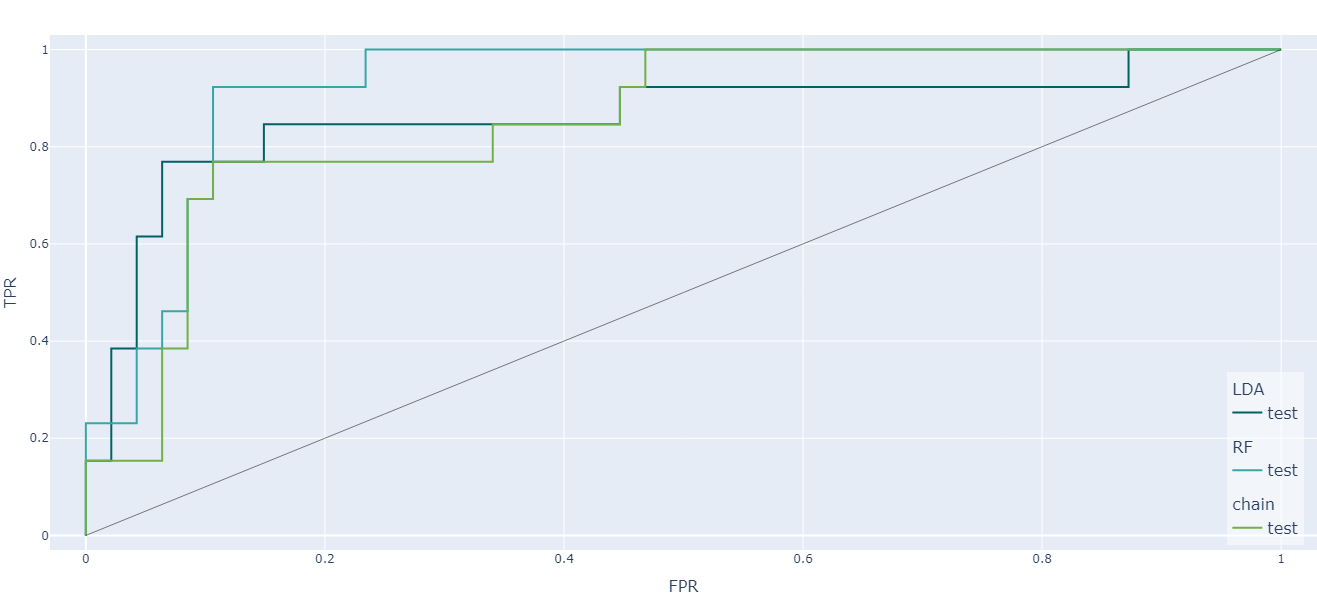

In [10]:
# Use the target parameter in plots to specify which target column to use
atom.plot_roc(target=2)

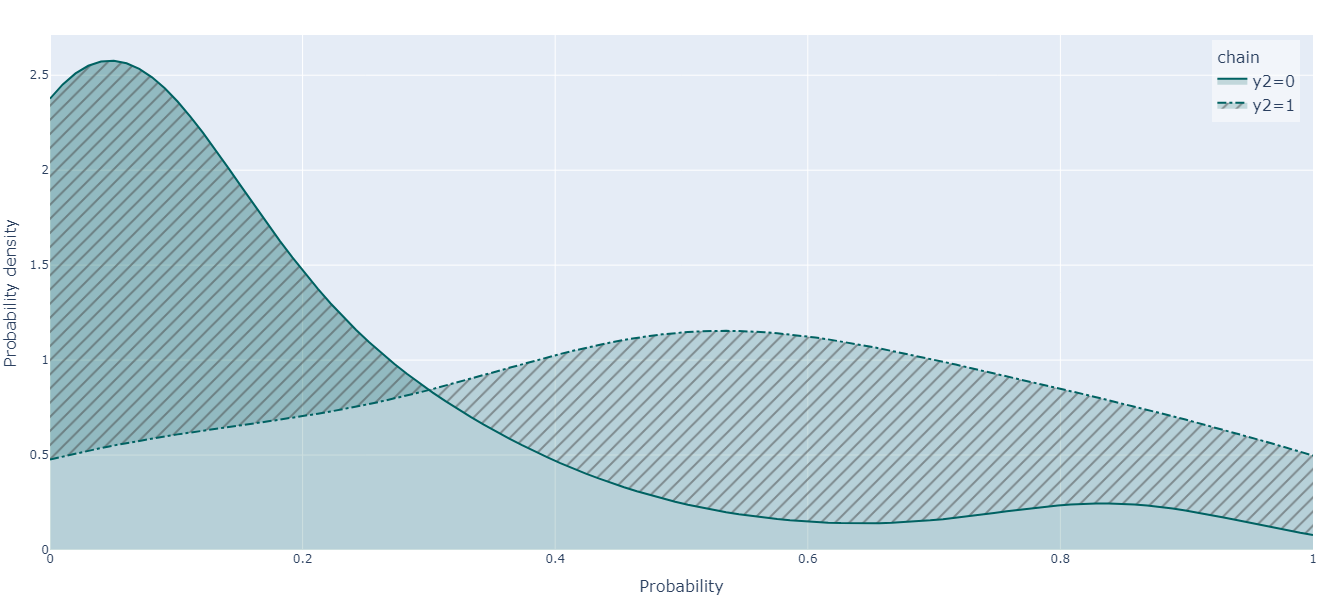

In [11]:
# When the target parameter also specifies the class, use format (column, class)
atom.plot_probabilities(models="chain", target=(2, 1))

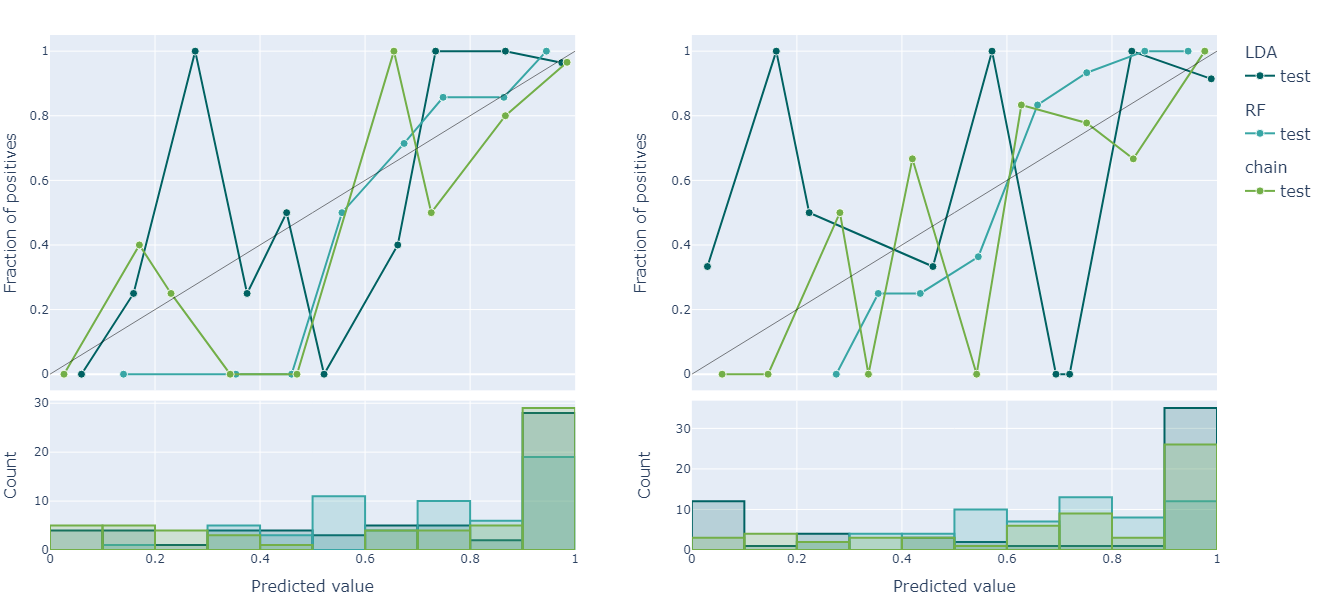

In [12]:
with atom.canvas(figsize=(900, 600)):
    atom.plot_calibration(target=0)
    atom.plot_calibration(target=1)